# DINEOF

In [1]:
import autoroot
from jaxtyping import Float, Array
import numpy as np
import xarray_einstats
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
import pandas as pd
import einx
from tqdm.auto import trange, tqdm
from sklearn.utils.extmath import randomized_svd, _randomized_eigsh
from da_toolz._src.ops.covariance import localize_covariance
from da_toolz._src.models.pca import pod_temporal_reconstruction, pod_svd_reconstruction
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.75)


%matplotlib inline

%load_ext autoreload
%autoreload 2

## Data

In [31]:
save_dir = "/pool/usuarios/juanjohn/data/ocean/obs/sst/clean/"

In [32]:
ds = xr.open_dataset(f"{save_dir}demo_sst_filled_2024.nc", engine="netcdf4")
ds_obs = xr.open_dataset(f"{save_dir}demo_sst_gaps_2024.nc", engine="netcdf4")["sst"]
ds["sst_obs"] = ds_obs.interp_like(ds)
ds

<xarray.Dataset> Size: 328MB
Dimensions:     (time: 93, lon: 871, lat: 253)
Coordinates:
  * time        (time) datetime64[ns] 744B 2024-01-01 2024-01-02 ... 2024-04-02
  * lon         (lon) float32 3kB -18.12 -18.06 -18.0 ... 36.12 36.19 36.25
  * lat         (lat) float32 1kB 30.25 30.31 30.38 30.44 ... 45.88 45.94 46.0
    ocean_mask  (lat, lon) int16 441kB ...
Data variables:
    sst         (time, lat, lon) float32 82MB ...
    mask        (time, lat, lon) float32 82MB ...
    sst_obs     (time, lat, lon) float64 164MB nan nan nan nan ... nan nan nan
Attributes: (12/49)
    Conventions:                CF-1.4
    title:                      Mediterranean SST Analysis, L4, 1/16deg daily...
    summary:                    Daily gap-free maps (L4) at 0.0625deg. x 0.06...
    references:                 Buongiorno Nardelli, B., C. Tronconi, a. Pisa...
    institution:                GOS (Global Ocean Satellite monitoring and ma...
    history:                    GOS-MYO processor V3: new version
    ...                         ...
    project:                    Copernicus Marine Environment Monitoring Serv...
    publisher_name:             CNR ISMAR GOS - CMEMS SST-TAC
    publisher_url:              http://marine.copernicus.eu/
    publisher_email:            servicedesk.cmems@mercator-ocean.eu, gsdk@art...
    processing_level:           L4
    cdm_data_type:              grid

### Rearrange Data

In [33]:
# tranpose
ds = ds.transpose("time", "lon", "lat")
ds = ds.stack(spatial=["lon", "lat"])

In [34]:
n_space = ds.spatial.shape[0]
n_time = ds.time.shape[0]

In [35]:
ds

<xarray.Dataset> Size: 332MB
Dimensions:     (time: 93, spatial: 220363)
Coordinates:
  * time        (time) datetime64[ns] 744B 2024-01-01 2024-01-02 ... 2024-04-02
    ocean_mask  (spatial) int16 441kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  * spatial     (spatial) object 2MB MultiIndex
  * lon         (spatial) float32 881kB -18.12 -18.12 -18.12 ... 36.25 36.25
  * lat         (spatial) float32 881kB 30.25 30.31 30.38 ... 45.88 45.94 46.0
Data variables:
    sst         (time, spatial) float32 82MB nan nan nan nan ... nan nan nan nan
    mask        (time, spatial) float32 82MB 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    sst_obs     (time, spatial) float64 164MB nan nan nan nan ... nan nan nan
Attributes: (12/49)
    Conventions:                CF-1.4
    title:                      Mediterranean SST Analysis, L4, 1/16deg daily...
    summary:                    Daily gap-free maps (L4) at 0.0625deg. x 0.06...
    references:                 Buongiorno Nardelli, B., C. Tronconi, a. Pisa...
    institution:                GOS (Global Ocean Satellite monitoring and ma...
    history:                    GOS-MYO processor V3: new version
    ...                         ...
    project:                    Copernicus Marine Environment Monitoring Serv...
    publisher_name:             CNR ISMAR GOS - CMEMS SST-TAC
    publisher_url:              http://marine.copernicus.eu/
    publisher_email:            servicedesk.cmems@mercator-ocean.eu, gsdk@art...
    processing_level:           L4
    cdm_data_type:              grid

## Missing Data

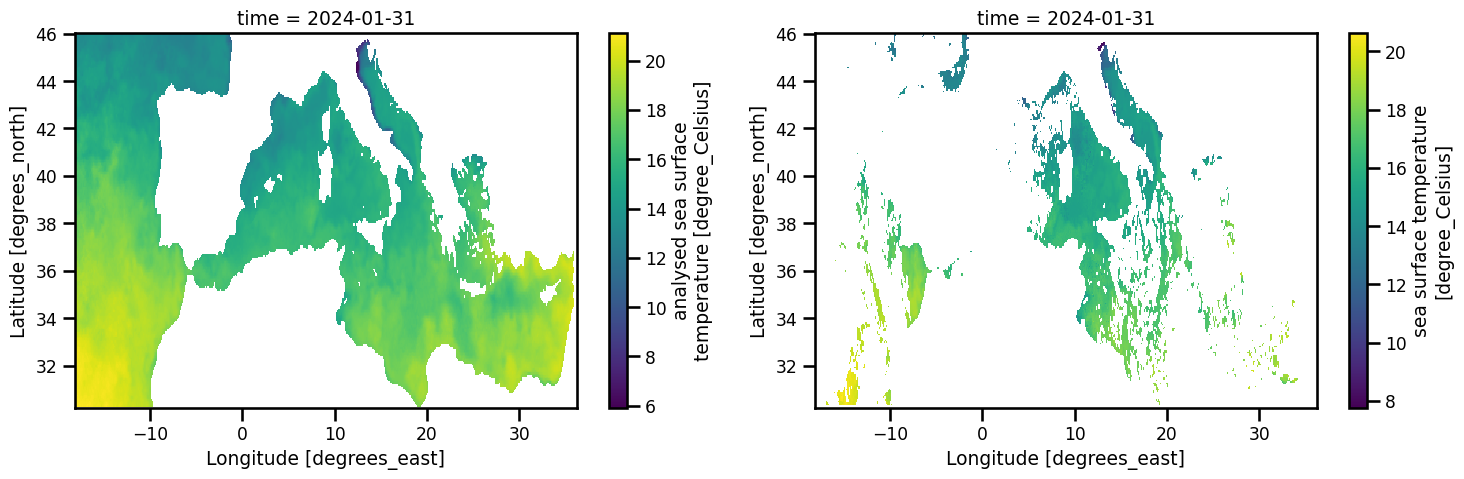

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
itime = 30
ds.sst.unstack().isel(time=itime).plot.pcolormesh(ax=ax[0], x="lon")
ds.sst_obs.unstack().isel(time=itime).plot.pcolormesh(ax=ax[1], x="lon")

plt.tight_layout()
plt.show()

In [37]:
ds.mask

<xarray.DataArray 'mask' (time: 93, spatial: 220363)> Size: 82MB
array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 744B 2024-01-01 2024-01-02 ... 2024-04-02
    ocean_mask  (spatial) int16 441kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  * spatial     (spatial) object 2MB MultiIndex
  * lon         (spatial) float32 881kB -18.12 -18.12 -18.12 ... 36.25 36.25
  * lat         (spatial) float32 881kB 30.25 30.31 30.38 ... 45.88 45.94 46.0
Attributes:
    long_name:      sea/land/lake/ice field composite mask
    flag_values:    [1 2 3 4]
    flag_meanings:  sea land lake ice
    valid_min:      1
    valid_max:      4
    source:         ---
    comment:        b0:1= sea; b1:1= land; b2:1= lake; b3:1= sea ice; b4-7: r...
    units:          dimensionless

## Initial Condition

In [42]:
data = ds[["sst_obs", "mask"]]
# ocean mask
data["ocean_mask"] = data.mask.where(data.mask == 1, other=0.0,).astype(bool)
# nan mask~
data["nan_mask"] = np.logical_and(np.isnan(data["sst_obs"]), data["ocean_mask"])
# values 
data["obs_mask"] = np.logical_and(~data["nan_mask"], data["ocean_mask"])
data["sst_init"] = data["sst_obs"].fillna(0.0)
# data["sst_init"] = data["sst_obs"].interpolate_na(dim="time", method="slinear", fill_value="extrapolate")
#
data = data.transpose("spatial", "time")

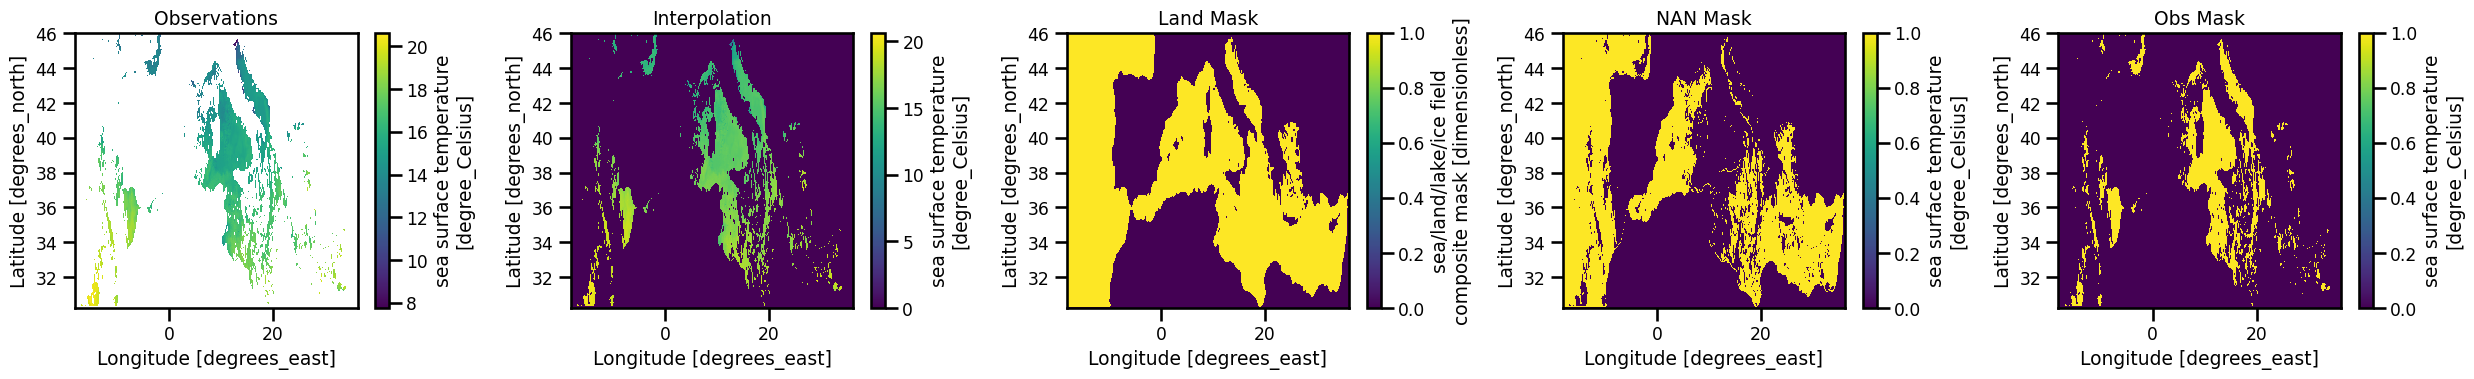

In [43]:
fig, ax = plt.subplots(ncols=5, figsize=(25,4))

itime = 30

data.sst_obs.isel(time=itime).unstack().plot.pcolormesh(x="lon", ax=ax[0], cmap="viridis")
data.sst_init.isel(time=itime).unstack().plot.pcolormesh(x="lon", ax=ax[1], cmap="viridis")
data.ocean_mask.isel(time=itime).unstack().plot.pcolormesh(x="lon",ax=ax[2],)
data.nan_mask.isel(time=itime).unstack().plot.pcolormesh(x="lon",ax=ax[3], )
data.obs_mask.isel(time=itime).unstack().plot.pcolormesh(x="lon",ax=ax[4], )

ax[0].set(title="Observations")
ax[1].set(title="Interpolation")
ax[2].set(title="Land Mask")
ax[3].set(title="NAN Mask")
ax[4].set(title="Obs Mask")


plt.tight_layout()
plt.show()

In [ ]:

err = 0.0
X = data.sst_init.values.copy()
nan_mask = data.nan_mask.values.copy()
obs_mask = data.obs_mask.values.copy()
ocean_mask = data.ocean_mask.values.copy()

# all remaining nans are 0.0
X[nan_mask] = 0.0
X[~ocean_mask] = 0.0

losses = []

In [54]:
num_components = 1
num_iters = 200

pbar = trange(num_iters, desc='Reconstruction', leave=True)
for i in pbar:

    # apply PCA decomposition
    X_recon = pod_svd_reconstruction(X=X.copy(), n_components=num_components, random_state=42)

    # set reconstructed values
    
    X_recon[obs_mask] = X[obs_mask].copy()
    X_recon[~ocean_mask] = 0.0

    err_new = np.sqrt(np.mean(np.power(X[nan_mask] - X_recon[nan_mask], 2))) / X[obs_mask].std()

    rel_error = abs(err_new - err)
    pbar.set_postfix(error=err_new, rel_error=rel_error)
    
    losses.append(err_new)

    # if rel_error < 1e-10:
    #     break

    err = err_new
    X = X_recon

Reconstruction:   0%|          | 0/200 [00:00<?, ?it/s]

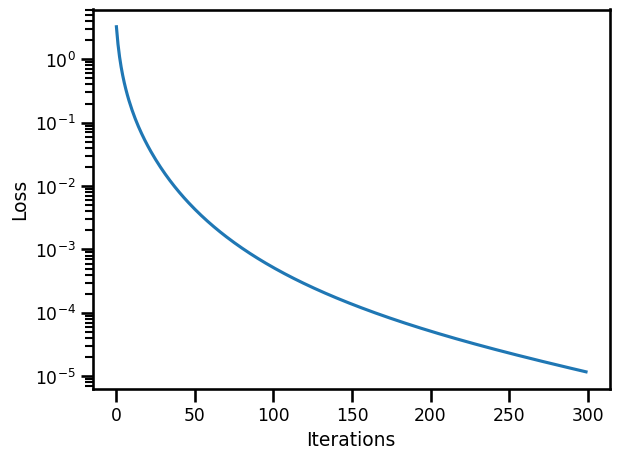

In [55]:
fig, ax = plt.subplots()

ax.plot(losses)

ax.set(xlabel="Iterations", ylabel="Loss", yscale="log")

plt.tight_layout()
plt.show()

In [56]:
# X[np.isnan(ds.sst.transpose('spatial','time').values)] = np.nan
data["sst_recon"] = (("spatial", "time"), X)

data["sst_recon"] = data["sst_recon"].where(data.sst_recon != 0, np.nan, drop=False)
data["sst_init"] = data["sst_init"].where(data.sst_init != 0, np.nan, drop=False)

In [59]:
# for itime in range(20):
#     fig, ax = plt.subplots(ncols=5, figsize=(25,4))
    
    
#     ds.sst.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0], cmap="viridis")
#     data.sst_obs.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1], cmap="viridis")
#     data.sst_init.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2], cmap="viridis")
#     data.sst_recon.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[3], cmap="viridis")
#     np.abs(ds.sst.isel(time=itime) - data.sst_recon.isel(time=itime)).unstack().plot.pcolormesh(x="lon",ax=ax[4],cmap="Reds", vmin=0.0, robust=True)
    
#     ax[0].set(title="Ground Truth")
#     ax[1].set(title="Missing Data")
#     ax[2].set(title="Initial Condition")
#     ax[3].set(title="Solution")
#     ax[4].set(title="Error")
#     plt.tight_layout()
#     plt.show()

## Multi-Components

In [48]:
X = data.sst_init.values.copy()
nan_mask = data.nan_mask.values.copy()
obs_mask = data.obs_mask.values.copy()
ocean_mask = data.ocean_mask.values.copy()

# all remaining nans are 0.0
X[nan_mask] = 0.0
X[~ocean_mask] = 0.0


In [49]:

num_iters = 250
num_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
pbar_components = tqdm(num_components, desc="Components")


err = 0.0
losses = []
X_recons = {}
for n in pbar_components:
    pbar = trange(num_iters, desc='Reconstruction', leave=False)
    for i in pbar:

        # apply PCA decomposition
        X_recon = pod_svd_reconstruction(X=X.copy(), n_components=n, random_state=42)
    
        # set reconstructed values
        
        X_recon[obs_mask] = X[obs_mask].copy()
        X_recon[~ocean_mask] = 0.0
    
        err_new = np.sqrt(np.mean(np.power(X[nan_mask] - X_recon[nan_mask], 2))) / X[obs_mask].std()
        
        rel_error = abs(err_new - err)
        pbar.set_postfix(error=err_new, rel_error=rel_error)
        losses.append(err_new)
        if rel_error < 1e-10:
            break

        err = err_new
        X = X_recon.copy()
        X_recons[n] = X.copy()
    pbar_components.set_postfix(error=err_new, rel_error=abs(err_new - err))


Components:   0%|          | 0/10 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()

ax.plot(losses)

ax.set(xlabel="Iterations", ylabel="Loss", yscale="log")

plt.tight_layout()
plt.show()

In [ ]:

for i in num_components:

    fig, ax = plt.subplots(ncols=5, figsize=(25,4))

    # X[np.isnan(ds.sst.transpose('spatial','time').values)] = np.nan
    data["sst_recon"] = (("spatial", "time"), X_recons[i])
    
    data["sst_recon"] = data["sst_recon"].where(data.sst_recon != 0, np.nan, drop=False)
    data["sst_init"] = data["sst_init"].where(data.sst_init != 0, np.nan, drop=False)

    itime = 50

    ds.sst.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0], cmap="viridis")
    data.sst_obs.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1], cmap="viridis")
    data.sst_init.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2], cmap="viridis")
    data.sst_recon.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[3], cmap="viridis")
    np.abs(ds.sst.isel(time=itime) - data.sst_recon.isel(time=itime)).unstack().plot.pcolormesh(x="lon",ax=ax[4],cmap="Reds")
    
    ax[0].set(title="Ground Truth")
    ax[1].set(title="Missing Data")
    ax[2].set(title="Initial Condition")
    ax[3].set(title="Solution")
    ax[4].set(title="Error")
    plt.tight_layout()
    plt.show()